Libraries

In [538]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import plotly.express as px

Styles

In [539]:
pd.options.mode.chained_assignment = None

In [568]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

In [541]:
%matplotlib inline

In [542]:
plt.rcParams['figure.figsize'] = (20,10)

In [543]:
saved_style_state = matplotlib.rcParams.copy()

In [544]:
pd.set_option('display.max_rows', None)

Reading files...

In [545]:
ev = pd.read_csv("IEA-EV-data.csv")

In [546]:
country = pd.read_csv("countries.csv")

In [547]:
energy = pd.read_csv("energy.csv")

In [548]:
renewable_share = pd.read_csv("renewable-share-energy.csv")

Cleaning file

In [549]:
world_geo = pd.read_csv("world_geo.csv")

world_geo = world_geo.rename({'gdp_md_est': 'sales'}, axis=1)

world_geo = world_geo[(world_geo.name != 'Antarctica')]

world_geo = world_geo.drop('Unnamed: 0', axis=1)

world_geo = world_geo.replace(0, np.nan)

world_geo = world_geo.sort_values(['name'])

items_geo = []

for c in world_geo.name:
    items_geo.append(c)

items_geo.pop()

items_geo.pop()

l = len(items_geo)

world_map = world_geo

Choropleth map (total electric vehicle sales)

In [550]:
fig = px.choropleth(world_map,
    locations = 'iso_a3',
    height = 750,
    color = 'sales',
    title = 'Total Electric Vehicle Sales per Country',
    range_color = [0, 1000000],
    color_continuous_scale = 'Greens',
    
)


fig.show()

Latest sales share

In [551]:
def sales_share_latest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    last = s.iloc[-1].value

    return last

Earliest sales share

In [552]:
def sales_share_earliest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    first = s.iloc[-2].value

    return first

List of all recorded countries

In [553]:
country_list = []

for c in ev.region:
    if c not in country_list:
        country_list.append(c)

country_list.remove('World')
country_list.remove('Europe')
country_list.remove('Rest of the world')
country_list.remove('Other Europe')
country_list.remove('Indonesia')
country_list.remove('Thailand')

country_list[15] = 'South Korea'

country_list = sorted(country_list)

country_list[-1] = country_list[-2]
country_list[-2] = 'United Kingdom'


Sales Share Lists

In [554]:
shares_latest = []
for c in country_list:
    if c == 'South Korea':
        shares_latest.append(f"{sales_share_latest('Korea')}")
    else:
        shares_latest.append(f"{sales_share_latest(c)}")

shares_earliest = []
for c in country_list:
    if c == 'South Korea':
        shares_earliest.append(f"{sales_share_earliest('Korea')}")
    else:
        shares_earliest.append(f"{sales_share_earliest(c)}")


shares_latest = list(map(float, shares_latest))
shares_earliest = list(map(float, shares_earliest))


l = len(shares_latest)
l2 = len(shares_earliest)


New Dataframe

In [555]:
df = pd.DataFrame({'2021': shares_latest})
df1 = pd.DataFrame({'2020': shares_earliest})
df2 = pd.DataFrame({'country': country_list})

all_shares = pd.concat([df2, df1, df], axis=1)

all_shares = all_shares.sort_values('2021')


Bar plot

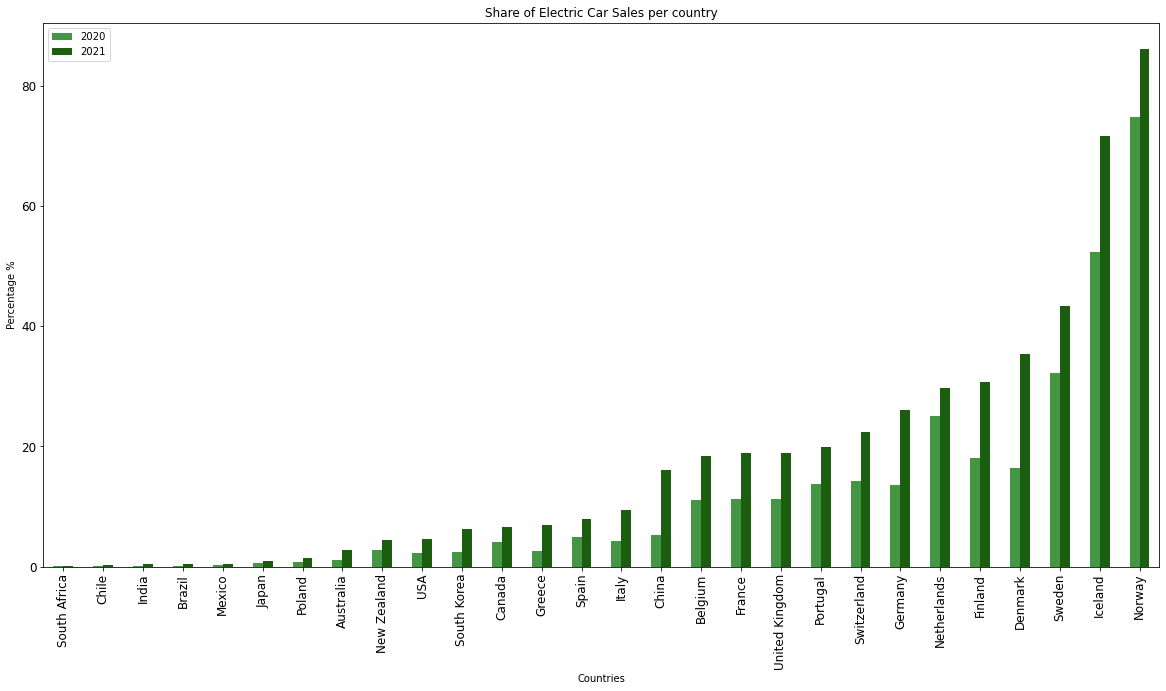

In [576]:

all_shares.plot(kind = 'bar', 
x = 'country', 
stacked = False,
title = 'Share of Electric Car Sales per country',
xlabel = 'Countries',
ylabel = 'Percentage %',
fontsize = '12',
color = {'2020': '#449644','2021': '#1b5e0f'}
)

plt.show()

Changing values in dataset

In [557]:
world_share = world_geo

world_share = world_share.sort_values('name')

world_share = world_share.rename(columns = {'sales': 'percentage'})

In [558]:
total_sales = []

for i in world_share.percentage:
    if i > 0:
        total_sales.append(i)

In [559]:
world_share['percentage'].replace(to_replace = total_sales, value = shares_latest, inplace = True)


Choropleth for ev sales share

In [577]:
fig2 = px.choropleth(world_share,
    locations = 'iso_a3',
    height = 750,
    color = 'percentage',
    title = 'Share of Electric Car Sales per country',
    range_color = [0,90],
    color_continuous_scale = 'Greens',
    
)


fig2.show()

Investigating energy data

In [561]:
energy = energy.dropna(axis=1, how='all')

In [562]:
def get_country(country):
    c = energy.index[energy['Country Name'] == country].tolist()
    
    a = energy.iloc[c]

    a = a.T

    a = list(a[c[0]])

    ax = []

    for i in a:
        if float == type(i):
            ax.append(i)

    r = pd.DataFrame(ax, columns=[country])
    
    return r

In [578]:
aus = get_country('Australia')

nor = get_country('Norway')

usa = get_country('United States')

nzl = get_country('New Zealand')

fin = get_country('Finland')

can = get_country('Canada')

swe = get_country('Sweden')

chi = get_country('China')

ice = get_country('Iceland')

In [564]:
years = list(range(1990,2021))

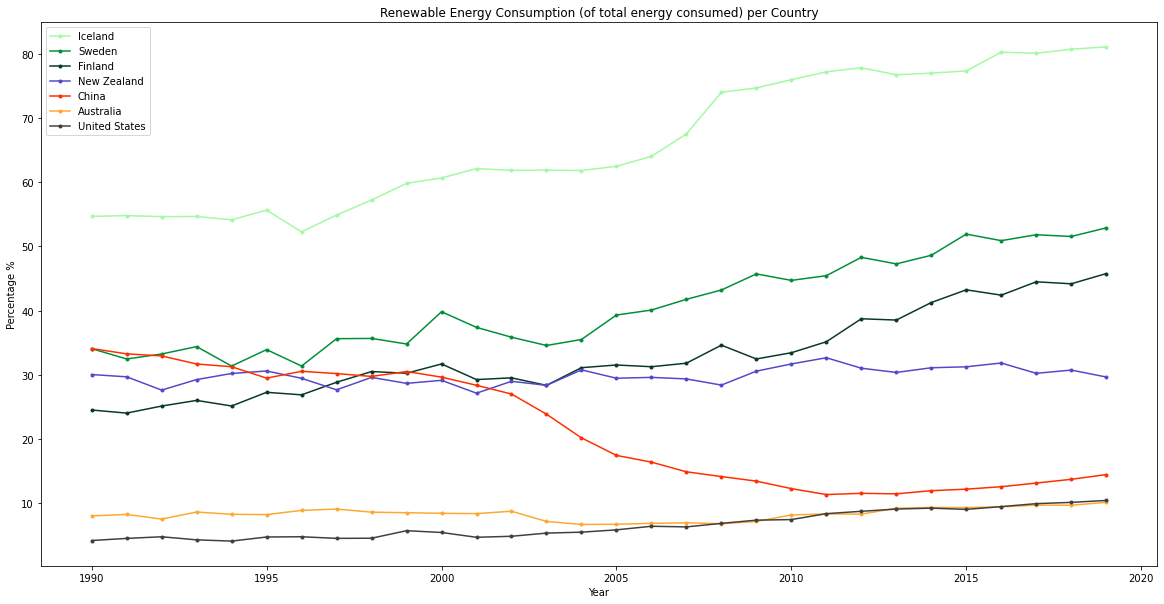

In [630]:
renewable = pd.DataFrame(years, columns=['Year'])


com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice], axis=1)



plt.title('Renewable Energy Consumption (of total energy consumed) per Country')
plt.plot(com_ren.Year, com_ren.Iceland, '.-', color='#A2FAA3', label='Iceland')
plt.plot(com_ren.Year, com_ren.Sweden, '.-', color='#008F39', label='Sweden')
plt.plot(com_ren.Year, com_ren.Finland, '.-', color='#093824', label='Finland')
plt.plot(com_ren.Year, com_ren['New Zealand'], '.-', color='#5448C8', label='New Zealand')
plt.plot(com_ren.Year,com_ren.China, '.-', color='#FF2E00', label='China')
plt.plot(com_ren.Year, com_ren.Australia, '.-', color='#FEA82F', label='Australia')
plt.plot(com_ren.Year, com_ren['United States'], '.-', color='#423E3B', label='United States')




plt.xlabel('Year')

plt.ylabel('Percentage %')

plt.legend(loc='upper left')


plt.show()


Investigating renewable share data 

In [677]:
is_21 = renewable_share.Year == 2021

share_21 = renewable_share[is_21]

share_21 = share_21.reset_index()

share_21 = share_21.drop('index', axis=1)



def get_2021(c):
    for i in range(len(share_21.Entity)):
        if share_21.Entity[i] == c:
            a = share_21['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c])

    return a


In [687]:
share_21

,Entity,Code,Year,Renewables (% equivalent primary energy)
0,Africa,NaN,2021,9.555876
1,Africa (BP),NaN,2021,9.574978
2,Algeria,DZA,2021,0.261367
3,Argentina,ARG,2021,11.329249
4,Asia,NaN,2021,10.954556


In [696]:
get_2021('Iceland')
get_2021('World')
get_2021('Europe')
get_2021('Africa')
get_2021('Asia')
get_2021('Asia Pacific (BP)')
get_2021('Trinidad and Tobago')

0.0071594668552279

In [703]:
lowest = 100
entity = []
for i in share_21.Entity:
    r = get_2021(i)
    if r < lowest:
        lowest = r
        entity.append(i)

print(f"{lowest}, {entity[-1]}")


highest = 0
ent = []
for j in share_21.Entity:
     k = get_2021(j)
     if k > highest:
        highest = k
        ent.append(j)

print(f"{highest}, {ent[-1]}")

0.0071594668552279, Trinidad and Tobago
86.8745346069336, Iceland
